In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qmcpy import Halton

# Smooth approximation of max
def softmax(a, b, tau=1e-4):
    return 0.5 * (a + b + np.sqrt((a - b)**2 + tau))

#Code for the L_2 star
def L2(L):
    n=len(L)
    a=0
    for i in range(n):
        a+=(1-L[i][0]**2)*(1-L[i][1]**2)
    a=a/(2*n)
    
    b=0
    for i in range(n):
        for j in range(n):
            b+=(1-max(L[i][0],L[j][0]))*(1-max(L[i][1],L[j][1]))
    b=b/(n**2)
    
    return(1/9-a+b)

def edge_penalty(P, epsilon=1e-9):
    """
    Penalize points near the boundary (x=0 or 1).
    P: array of shape (n, d)
    epsilon: small constant to avoid division by zero
    """
    return np.sum(1.0 / ((P + epsilon) * (1.0 - P + epsilon)))

def repulsion_penalty(P, epsilon=1e-9):
    n = len(P)
    total = 0.0
    for i in range(n):
        for j in range(i+1, n):
            dist_squared = np.sum((P[i] - P[j])**2)
            total += 1.0 / (dist_squared + epsilon)
    return total

# Smoothed L2 star discrepancy objective
def L2_smoothed(P, tau=1e-4):
    n = len(P)
    a=0
    for i in range(n):
        a+=(1-P[i][0]**2)*(1-P[i][1]**2)
    a=a/(2*n)

    b = 0
    for i in range(n):
        for j in range(n):
            smax0 = softmax(P[i, 0], P[j, 0], tau)
            smax1 = softmax(P[i, 1], P[j, 1], tau)
            b += (1 - smax0) * (1 - smax1)
    b = b / (n**2)

    return 1/9 - a + b

# Smoothed L2 star discrepancy objective
def L2_updated(P, tau=1e-4):
    n = len(P)
    a=0
    for i in range(n):
        a+=(1-P[i][0]**2)*(1-P[i][1]**2)
    a=a/(2*n)

    b = 0
    for i in range(n):
        for j in range(n):
            smax0 = softmax(P[i, 0], P[j, 0], tau)
            smax1 = softmax(P[i, 1], P[j, 1], tau)
            b += (1 - smax0) * (1 - smax1)
    b = b / (n**2)

    return 1/9 - a + b + 1e-7 * edge_penalty(P) + 1e-8 * repulsion_penalty(P)

# Project points to [0,1)
def project_to_unit_cube(P):
    return np.clip(P, 0, 1 - 1e-8)

def locdisc(x, y, P):
    no = 0
    nc = 0
    n = len(P)
    for i in range(n):
        if P[i][0] < x and P[i][1] < y:
            no += 1
        if P[i][0] <= x and P[i][1] <= y:
            nc += 1
    return max(x*y - no/n, nc/n - x*y)

def heatmap_from_array(P):  # P should be a NumPy array of shape (n, 2)
    n = len(P)
    PX = P[:, 0]
    PY = P[:, 1]
    
    X = [0.001 * i for i in range(1001)]
    Y = [0.001 * i for i in range(1001)]
    Z = [[0 for _ in range(1001)] for _ in range(1001)]
    
    maxi = 0
    mxii = 0
    mxjj = 0
    for i in range(1001):
        for j in range(1001):
            Z[j][i] = locdisc(X[i], Y[j], P)
            if Z[j][i] > maxi:
                maxi = Z[j][i]
                mxii = i
                mxjj = j

    plt.figure(figsize=(7,6))
    cs = plt.contourf(X, Y, Z, levels=40, cmap="viridis")
    plt.colorbar(cs)
    plt.scatter(PX, PY, c='r', s=50, linewidth=1, alpha=0.7)
    plt.scatter(mxii/1000, mxjj/1000, c='black')
    plt.title("Local Discrepancy Heatmap")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.show()

In [2]:
def PGD_L2(start_points, max_iters=100, alpha=0.1, beta=0.5, tau=1e-4, tol=1e-6):
    n = len(start_points)
    P = start_points.copy()
    obj_values = []

    for it in range(max_iters):
        grad = np.zeros_like(P)
        eps = 1e-6
        f_val = L2_smoothed(P, tau)

        # Finite difference gradient
        for i in range(n):
            for j in range(2):
                P_perturbed = P.copy()
                P_perturbed[i, j] += eps
                f_perturbed = L2_smoothed(P_perturbed, tau)
                grad[i, j] = (f_perturbed - f_val) / eps

        # Backtracking line search
        t = 1.0
        while True:
            new_P = project_to_unit_cube(P - t * grad)
            if L2_smoothed(new_P, tau) <= f_val - alpha * t * np.sum(grad**2):
                break
            t *= beta
            if t < 1e-8:
                break

        P_new = new_P
        obj_new = L2(P_new)
        obj_values.append(obj_new)

        if np.linalg.norm(P_new - P) < tol:
            break
        P = P_new

    return P, obj_values

In [3]:
def PGD_L2_updated(start_points, max_iters=100, alpha=0.1, beta=0.5, tau=1e-4, tol=1e-6):
    n = len(start_points)
    P = start_points.copy()
    obj_values = []

    for it in range(max_iters):
        grad = np.zeros_like(P)
        eps = 1e-6
        f_val = L2_updated(P, tau)

        # Finite difference gradient
        for i in range(n):
            for j in range(2):
                P_perturbed = P.copy()
                P_perturbed[i, j] += eps
                f_perturbed = L2_updated(P_perturbed, tau)
                grad[i, j] = (f_perturbed - f_val) / eps

        # Backtracking line search
        t = 1.0
        while True:
            new_P = project_to_unit_cube(P - t * grad)
            if L2_updated(new_P, tau) <= f_val - alpha * t * np.sum(grad**2):
                break
            t *= beta
            if t < 1e-8:
                break

        P_new = new_P
        obj_new = L2(P_new)
        obj_values.append(obj_new)

        if np.linalg.norm(P_new - P) < tol:
            break
        P = P_new

    return P, obj_values

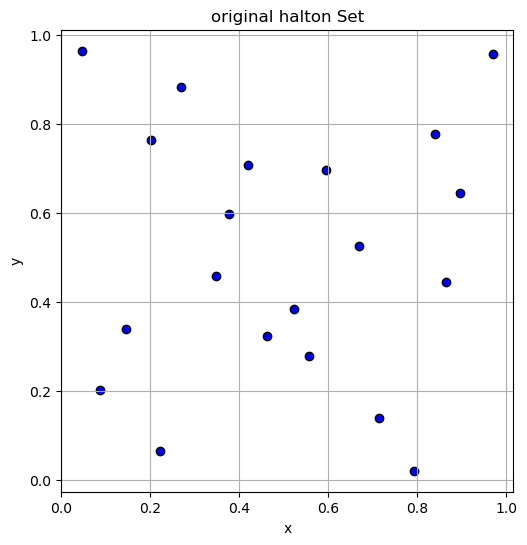

Points: [[0.42000761 0.70773045]
 [0.52250915 0.38314453]
 [0.22090141 0.06390513]
 [0.83902408 0.77827489]
 [0.34689589 0.45914277]
 [0.71302209 0.13866641]
 [0.04600977 0.96460649]
 [0.89651474 0.64537269]
 [0.46215397 0.3221196 ]
 [0.59388818 0.69557063]
 [0.14561224 0.33938451]
 [0.79297535 0.02014504]
 [0.2695931  0.8831203 ]
 [0.66898698 0.52562948]
 [0.08614238 0.20235946]
 [0.96990752 0.9583407 ]
 [0.37675132 0.59795462]
 [0.55548769 0.27749526]
 [0.20110552 0.76337897]
 [0.86421299 0.44428063]]


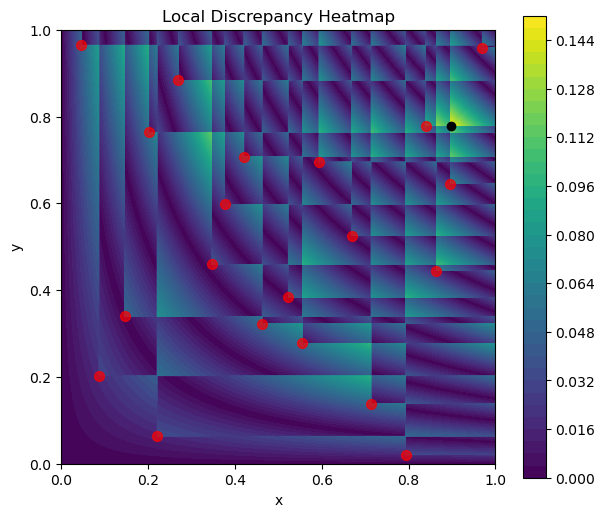

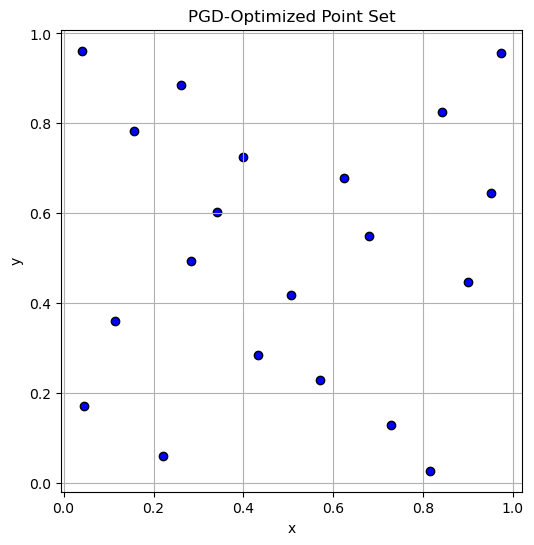

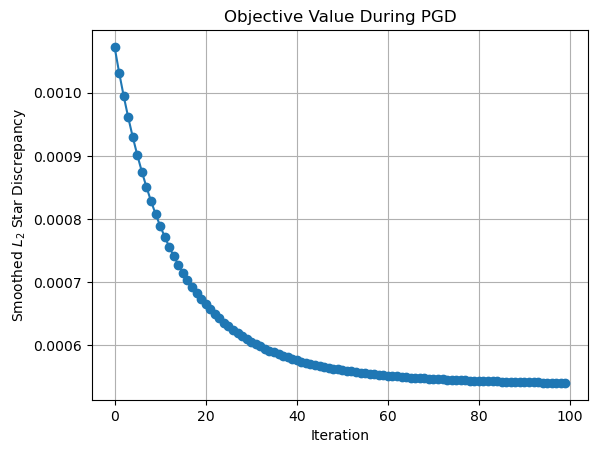

initial set L2 star discrepancy: 0.0011170394640936526
Final discrepancy value: 0.0005400025930314134
Points: [[0.39984652 0.72506369]
 [0.50550854 0.41675417]
 [0.22019487 0.06025158]
 [0.84266717 0.82507182]
 [0.28443046 0.49411783]
 [0.72783872 0.12745872]
 [0.04159675 0.96148952]
 [0.95202239 0.64406006]
 [0.4327162  0.28376051]
 [0.6235436  0.67744495]
 [0.1151995  0.36029326]
 [0.81604314 0.02673448]
 [0.26114745 0.88425601]
 [0.6788048  0.54860507]
 [0.0462198  0.17171557]
 [0.97415785 0.95646237]
 [0.34034267 0.60279623]
 [0.57141956 0.22859935]
 [0.15722473 0.7838098 ]
 [0.89921419 0.44578535]]


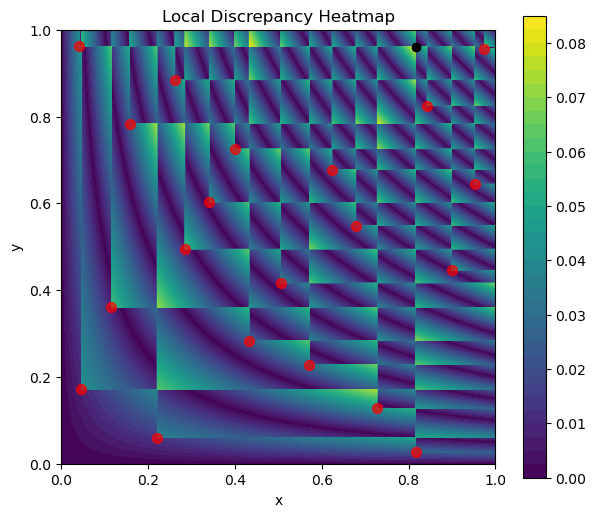

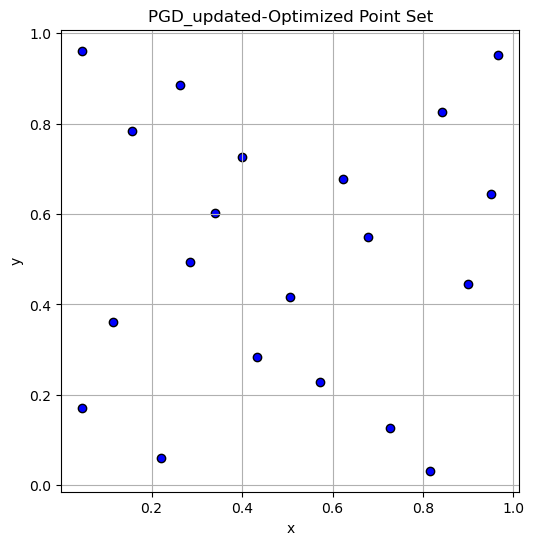

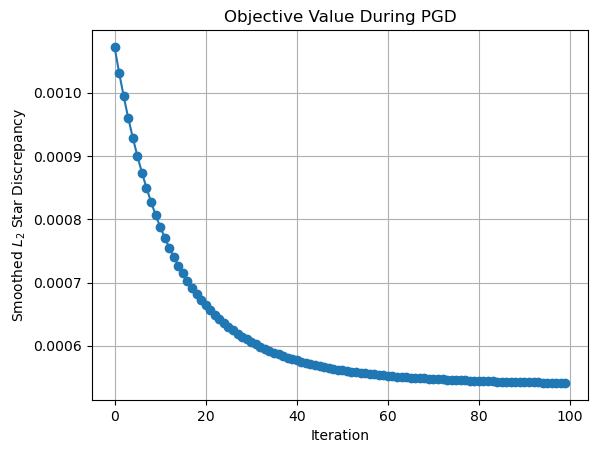

initial set L2 star discrepancy: 0.0011170394640936526
Final discrepancy value: 0.0005412602408152861
Points: [[0.40020375 0.7252558 ]
 [0.50566754 0.41684507]
 [0.22032055 0.06060496]
 [0.8425381  0.82521047]
 [0.28437921 0.49390519]
 [0.72786937 0.12778345]
 [0.04657152 0.96096258]
 [0.9512214  0.64403431]
 [0.43261802 0.283622  ]
 [0.62362046 0.67769334]
 [0.1153659  0.36027694]
 [0.81613223 0.03221222]
 [0.26171075 0.88426049]
 [0.67895577 0.54844382]
 [0.04648606 0.17169593]
 [0.96657802 0.95202989]
 [0.34048312 0.60280027]
 [0.5715913  0.2284954 ]
 [0.15720614 0.7836323 ]
 [0.8991427  0.44560748]]


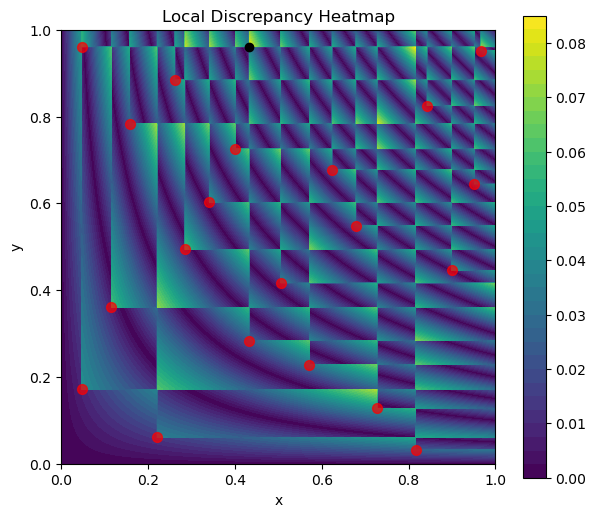

In [4]:
n = 20
d = 2
halton_net = Halton(dimension=d)
init_points = halton_net.gen_samples(n)

plt.figure(figsize=(6,6))
plt.scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
plt.title("original halton Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

print("Points:", init_points)

heatmap_from_array(init_points)



initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)




initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2_updated(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD_updated-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)

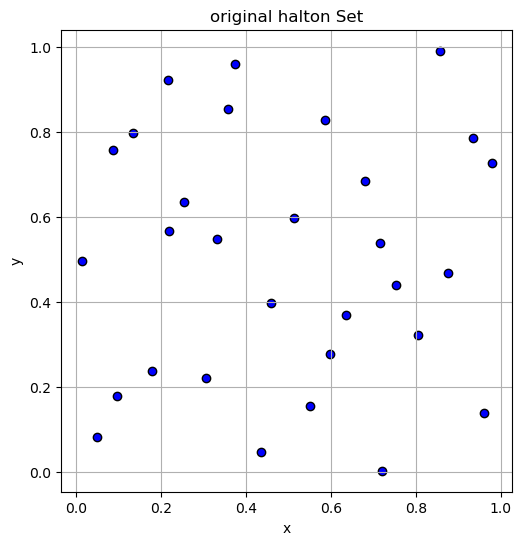

Points: [[0.71607299 0.5386073 ]
 [0.09804731 0.17768987]
 [0.93538917 0.78385439]
 [0.25482975 0.6339592 ]
 [0.59773735 0.2771551 ]
 [0.21601101 0.92079691]
 [0.75440155 0.43855005]
 [0.43520131 0.04514917]
 [0.67932037 0.68423739]
 [0.01438709 0.49546942]
 [0.96000419 0.1386484 ]
 [0.35760464 0.85226598]
 [0.51443762 0.59634025]
 [0.17961126 0.23587811]
 [0.85777343 0.99019266]
 [0.46042096 0.39585051]
 [0.71953489 0.00201127]
 [0.08780476 0.756307  ]
 [0.87534079 0.46608071]
 [0.3061444  0.22084492]
 [0.58750439 0.82699438]
 [0.2194748  0.56600313]
 [0.80571811 0.3202951 ]
 [0.37516242 0.95938143]
 [0.6348276  0.36915636]
 [0.05000496 0.08231113]
 [0.97902173 0.72596987]
 [0.33166535 0.54815067]
 [0.55007651 0.15429818]
 [0.13514708 0.79749974]]


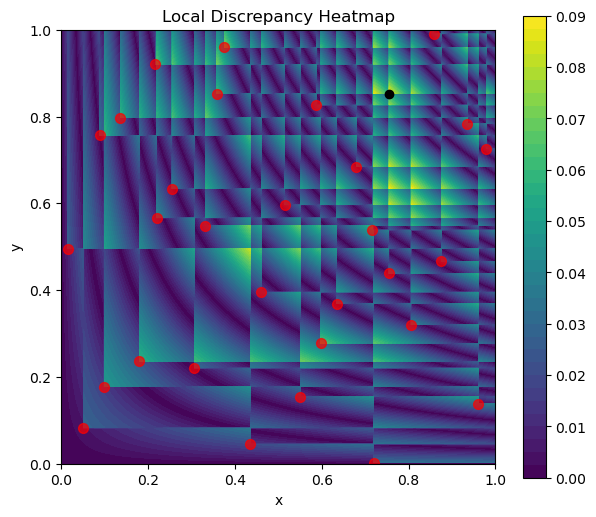

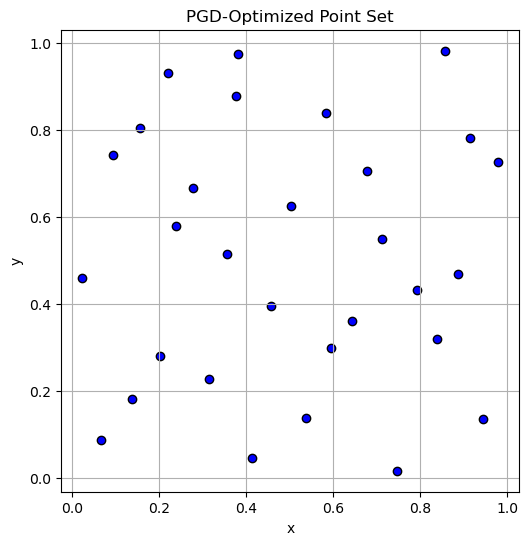

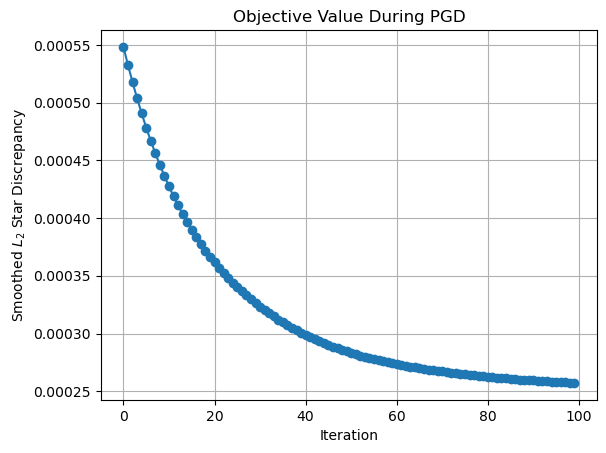

initial set L2 star discrepancy: 0.0005650592932370108
Final discrepancy value: 0.00025722875383570043
Points: [[0.71308766 0.54816358]
 [0.13824302 0.18000767]
 [0.91485931 0.78079713]
 [0.27784012 0.6653271 ]
 [0.59558863 0.29903212]
 [0.2195068  0.93014881]
 [0.79226869 0.43246546]
 [0.41219083 0.04446588]
 [0.67815032 0.70540268]
 [0.02283283 0.4589275 ]
 [0.94423607 0.13533115]
 [0.37697606 0.87675444]
 [0.50252809 0.62441327]
 [0.20117522 0.2797961 ]
 [0.85633889 0.98159124]
 [0.45587714 0.39420433]
 [0.74694089 0.0160648 ]
 [0.09341102 0.74190192]
 [0.88679893 0.4676274 ]
 [0.3140464  0.22666786]
 [0.5829562  0.8375106 ]
 [0.23902962 0.57832248]
 [0.83941577 0.31927228]
 [0.38205824 0.97437769]
 [0.64202967 0.36002614]
 [0.06642236 0.08728517]
 [0.97935223 0.72479855]
 [0.35587161 0.51478348]
 [0.53733117 0.13782772]
 [0.15505459 0.80434879]]


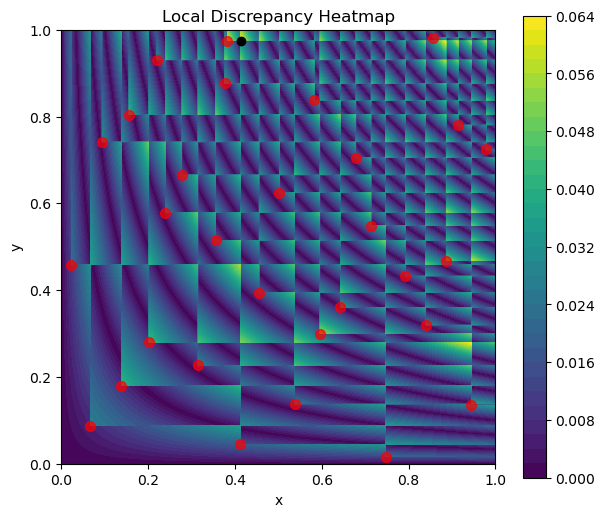

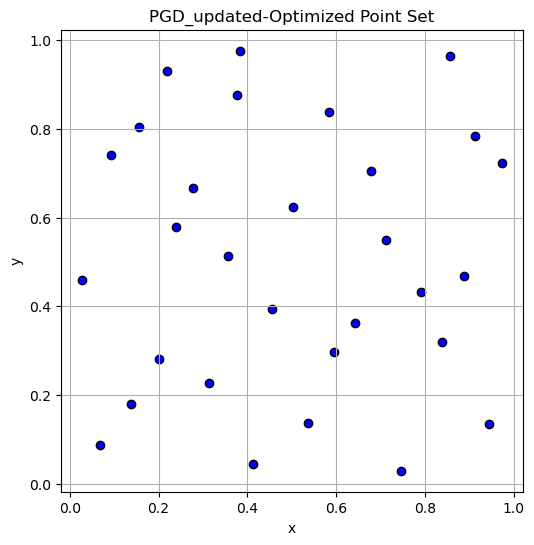

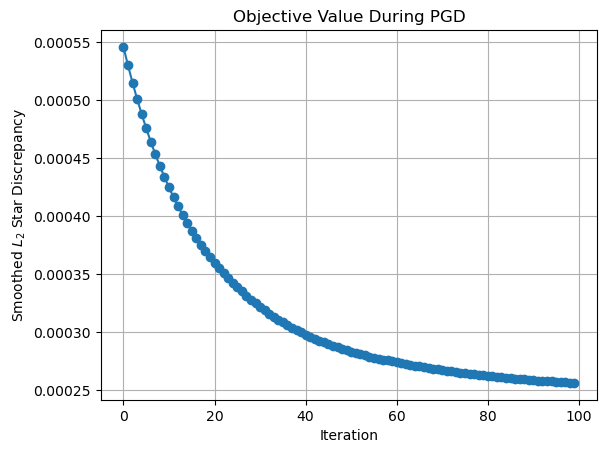

initial set L2 star discrepancy: 0.0005650592932370108
Final discrepancy value: 0.0002564933355477944
Points: [[0.71288283 0.54889861]
 [0.13821871 0.18003799]
 [0.91415123 0.78386314]
 [0.27826067 0.66595895]
 [0.59497541 0.29762113]
 [0.21926843 0.93026428]
 [0.79180789 0.43238209]
 [0.41208043 0.04491889]
 [0.67819931 0.70554111]
 [0.02796344 0.45861212]
 [0.94417152 0.13556032]
 [0.37714826 0.87634956]
 [0.50244946 0.62442462]
 [0.20110866 0.28045788]
 [0.85598538 0.96357358]
 [0.45581466 0.39416182]
 [0.74673004 0.02921536]
 [0.09225577 0.74155225]
 [0.88841569 0.46853851]
 [0.31425649 0.22658839]
 [0.58316857 0.83808489]
 [0.23823776 0.57763603]
 [0.83947645 0.31842667]
 [0.38266868 0.9761635 ]
 [0.64254688 0.36119968]
 [0.06675467 0.08723135]
 [0.97374384 0.72216163]
 [0.35603453 0.51438606]
 [0.53737523 0.13779412]
 [0.15636976 0.80517096]]


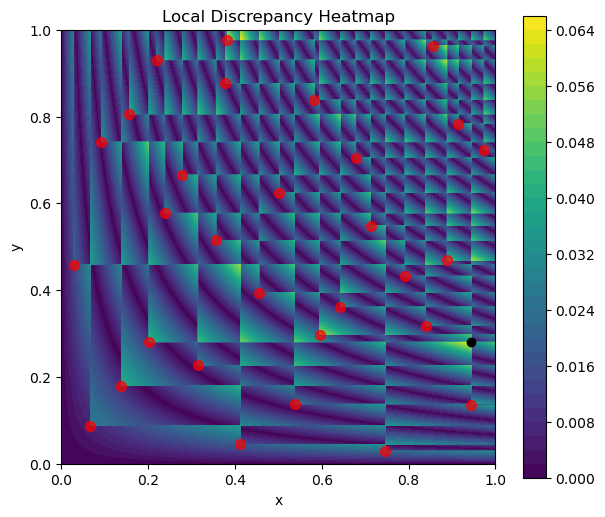

In [9]:
n = 30
d = 2
halton_net = Halton(dimension=d)
init_points = halton_net.gen_samples(n)

plt.figure(figsize=(6,6))
plt.scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
plt.title("original halton Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

print("Points:", init_points)

heatmap_from_array(init_points)



initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)




initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2_updated(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD_updated-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)

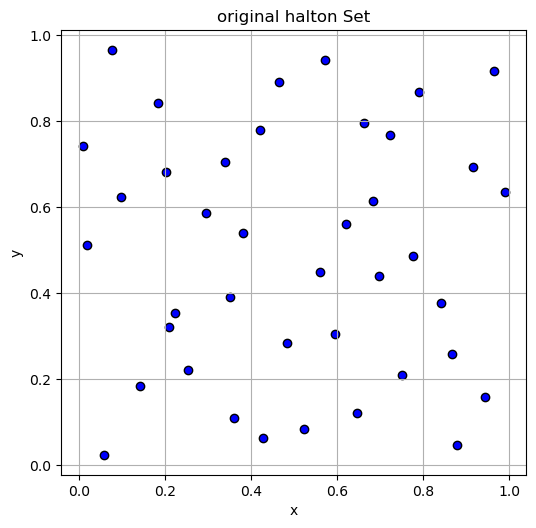

Points: [[0.75200703 0.20961234]
 [0.20272086 0.68188382]
 [0.68406905 0.61261886]
 [0.36122405 0.10907209]
 [0.96529642 0.91589128]
 [0.01751147 0.51207367]
 [0.59571864 0.30482319]
 [0.42149448 0.77830898]
 [0.84143564 0.37571577]
 [0.14084391 0.18352319]
 [0.72248824 0.76695164]
 [0.29521125 0.58657936]
 [0.87876042 0.04594074]
 [0.07642333 0.96392743]
 [0.56022448 0.44899628]
 [0.48457079 0.28284976]
 [0.78981501 0.86749684]
 [0.2239892  0.35378557]
 [0.6471862  0.12042948]
 [0.33904967 0.70380896]
 [0.99095839 0.63459236]
 [0.05776174 0.02399951]
 [0.57110385 0.94193102]
 [0.38021609 0.53816797]
 [0.86661601 0.25678674]
 [0.18256379 0.84139126]
 [0.69638286 0.43884189]
 [0.2543973  0.21990054]
 [0.91511023 0.69343904]
 [0.09818472 0.62371439]
 [0.52282761 0.08353764]
 [0.46383741 0.88918951]
 [0.77704065 0.48613774]
 [0.20913941 0.32044009]
 [0.66187361 0.79398431]
 [0.35190626 0.38970756]
 [0.9431458  0.15680309]
 [0.00811833 0.74140501]
 [0.62082949 0.5606225 ]
 [0.4278663  0.06

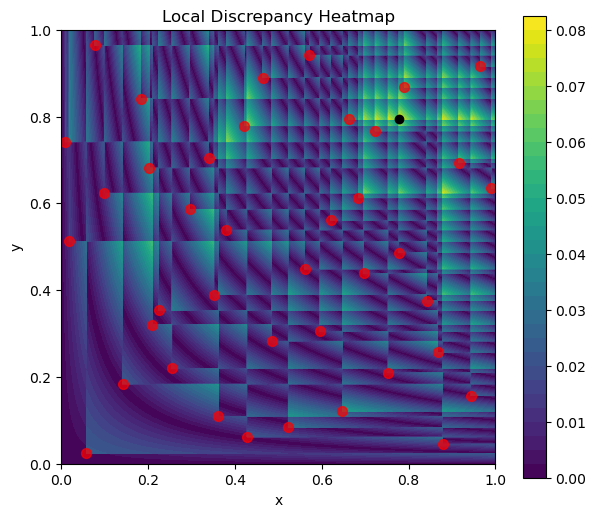

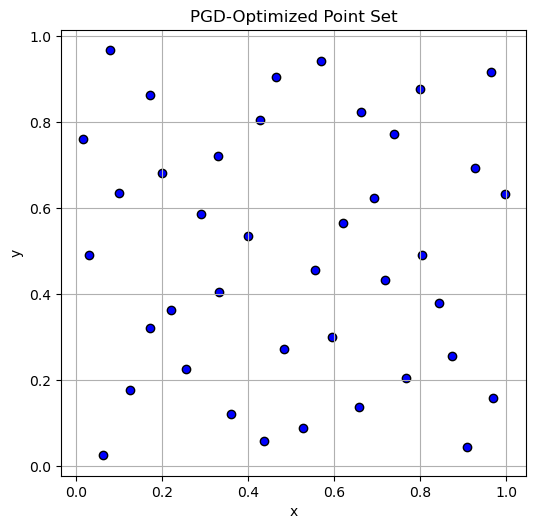

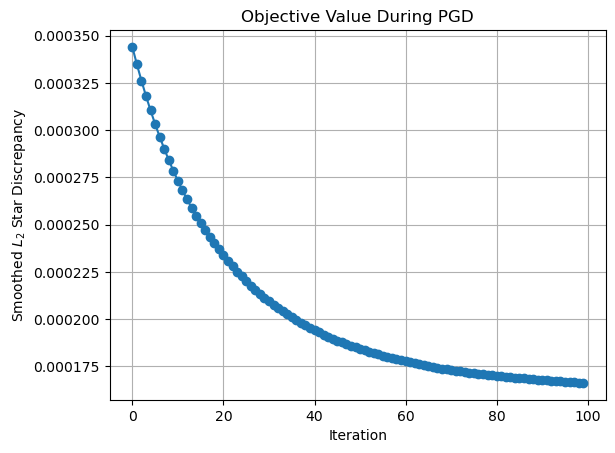

initial set L2 star discrepancy: 0.0003538239176110042
Final discrepancy value: 0.00016631223056751132
Points: [[0.76639029 0.20413024]
 [0.19933858 0.6828925 ]
 [0.69336017 0.62458259]
 [0.36010013 0.12008318]
 [0.96571157 0.9165823 ]
 [0.03002926 0.49025205]
 [0.59454254 0.30147669]
 [0.42671767 0.804358  ]
 [0.84260101 0.37947766]
 [0.12406547 0.17663798]
 [0.73966264 0.77362019]
 [0.28969244 0.58765223]
 [0.90834742 0.04382954]
 [0.07792061 0.96749735]
 [0.55403612 0.45648651]
 [0.48409359 0.27267039]
 [0.79963159 0.87833521]
 [0.2202762  0.36206927]
 [0.65869107 0.13649583]
 [0.33026762 0.72171747]
 [0.99794138 0.63428494]
 [0.061521   0.0246252 ]
 [0.56934844 0.94247412]
 [0.39816325 0.53487518]
 [0.87408178 0.25626893]
 [0.17211357 0.8636029 ]
 [0.71813756 0.4340726 ]
 [0.25520019 0.22574964]
 [0.9282928  0.69477859]
 [0.0994037  0.63545047]
 [0.52636528 0.0876577 ]
 [0.46543944 0.90530481]
 [0.80382136 0.49076428]
 [0.17082675 0.32060266]
 [0.66206033 0.82353368]
 [0.33263912 0

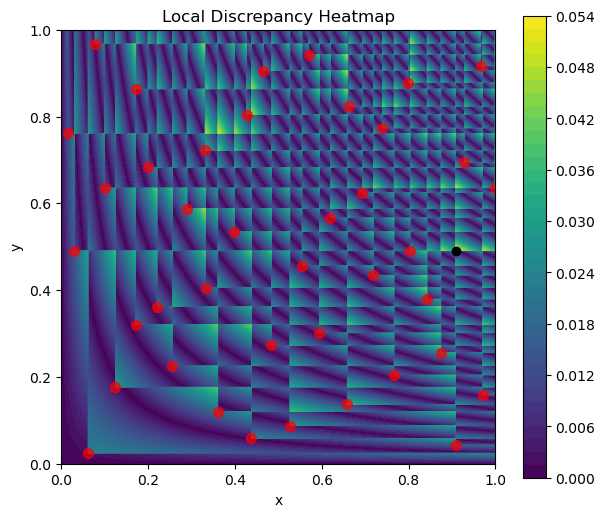

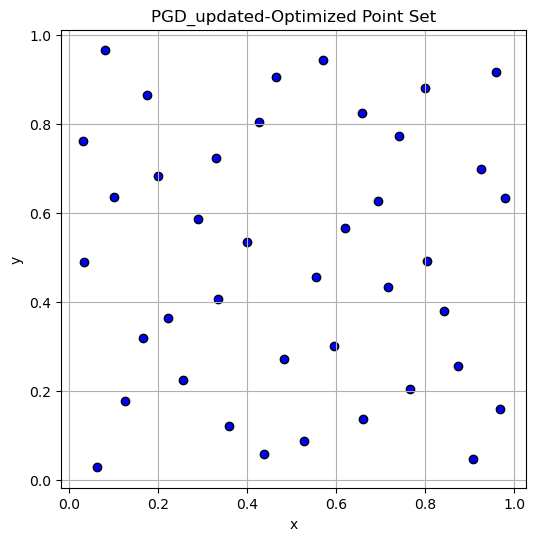

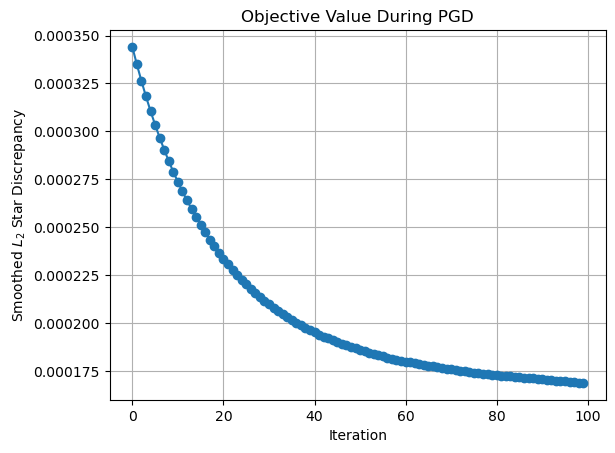

initial set L2 star discrepancy: 0.0003538239176110042
Final discrepancy value: 0.00016877067843262816
Points: [[0.7660274  0.20405492]
 [0.20031542 0.68386526]
 [0.69414855 0.62611957]
 [0.35925311 0.12061643]
 [0.95981527 0.91753924]
 [0.03179545 0.48963118]
 [0.5948452  0.30211862]
 [0.42697129 0.80491275]
 [0.84267965 0.37917911]
 [0.12390778 0.17650603]
 [0.74121007 0.77349342]
 [0.28929945 0.5875536 ]
 [0.90768384 0.04646761]
 [0.07894519 0.96563307]
 [0.55353655 0.45646553]
 [0.48354456 0.27259554]
 [0.80003508 0.88041583]
 [0.22210694 0.36479954]
 [0.65977649 0.13606054]
 [0.33001464 0.7227877 ]
 [0.9801627  0.63334996]
 [0.0620706  0.02911653]
 [0.57035127 0.943183  ]
 [0.39869765 0.53492775]
 [0.87404362 0.256479  ]
 [0.17461151 0.86443903]
 [0.717178   0.43349838]
 [0.25544021 0.22541223]
 [0.92618325 0.69834279]
 [0.09921029 0.63544938]
 [0.52701974 0.08804755]
 [0.46487721 0.90658967]
 [0.8044326  0.49278906]
 [0.16637878 0.31830525]
 [0.65837637 0.82546649]
 [0.33342201 0

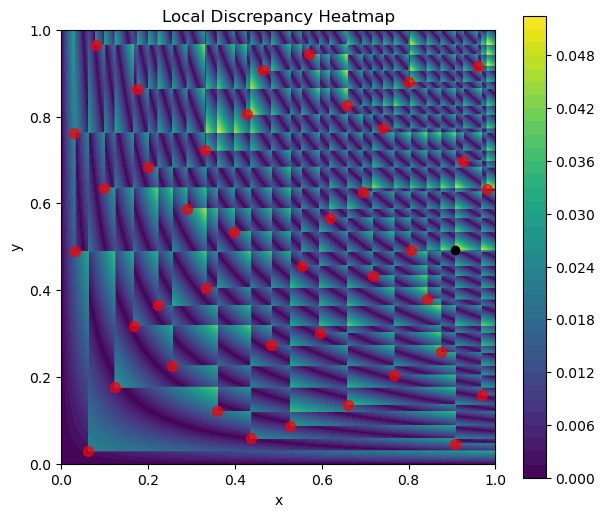

In [11]:
n = 40
d = 2
halton_net = Halton(dimension=d)
init_points = halton_net.gen_samples(n)

plt.figure(figsize=(6,6))
plt.scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
plt.title("original halton Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

print("Points:", init_points)

heatmap_from_array(init_points)



initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)




initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2_updated(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD_updated-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)

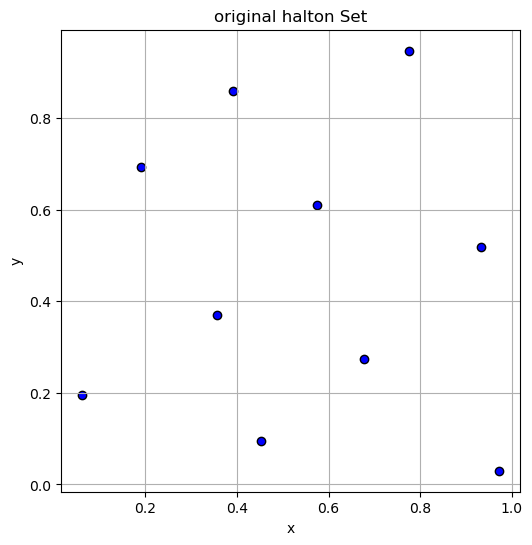

Points: [[0.97286532 0.02994098]
 [0.39063969 0.85960309]
 [0.57419909 0.61047306]
 [0.06231617 0.19561205]
 [0.77525531 0.9466345 ]
 [0.3573363  0.37011606]
 [0.67779758 0.27441308]
 [0.18959627 0.69393176]
 [0.93344714 0.51932622]
 [0.45305071 0.09395195]]


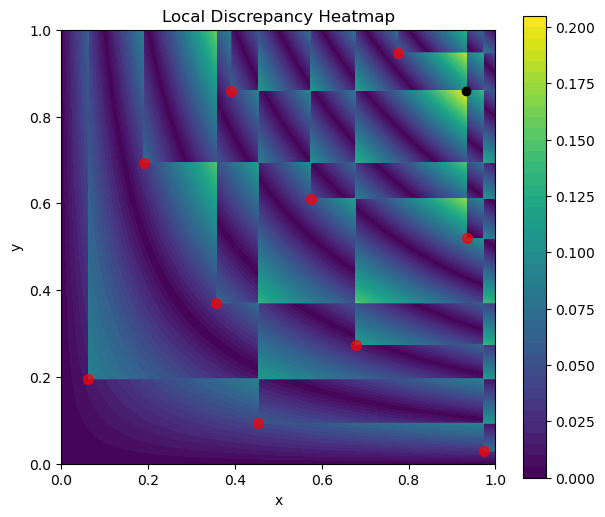

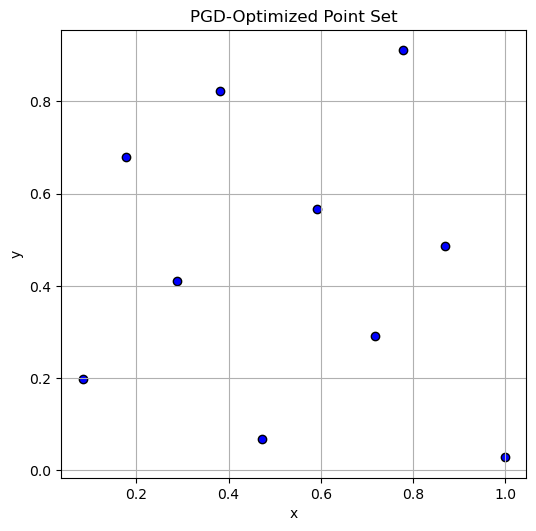

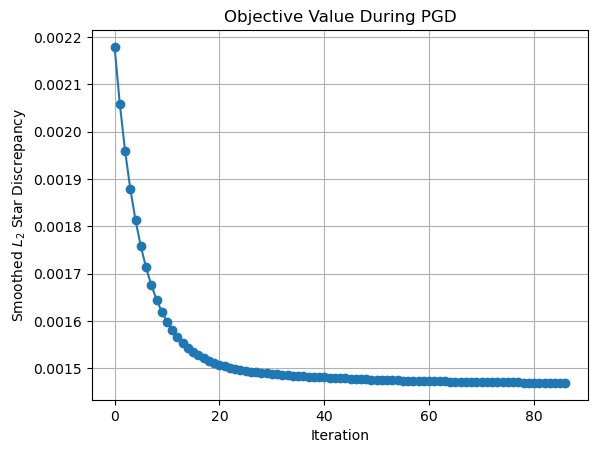

initial set L2 star discrepancy: 0.002326497201966496
Final discrepancy value: 0.001468876052105772
Points: [[0.99999999 0.02794793]
 [0.38209336 0.82269626]
 [0.5911545  0.56717985]
 [0.08322412 0.19841415]
 [0.77736146 0.91056987]
 [0.28878749 0.4093883 ]
 [0.71792507 0.2904597 ]
 [0.17754191 0.68040152]
 [0.86960779 0.48637504]
 [0.47207955 0.06769872]]


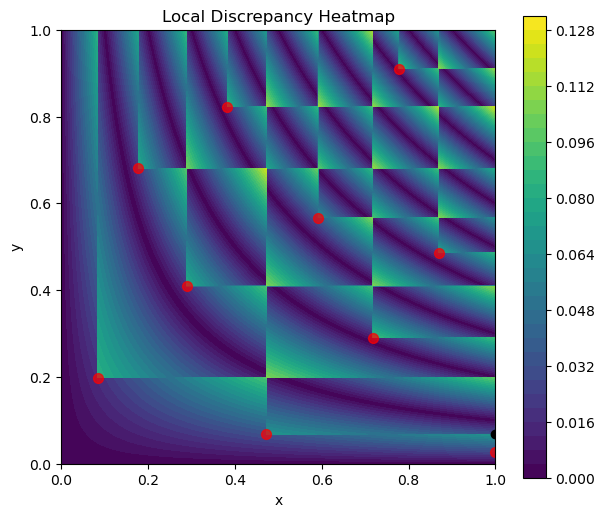

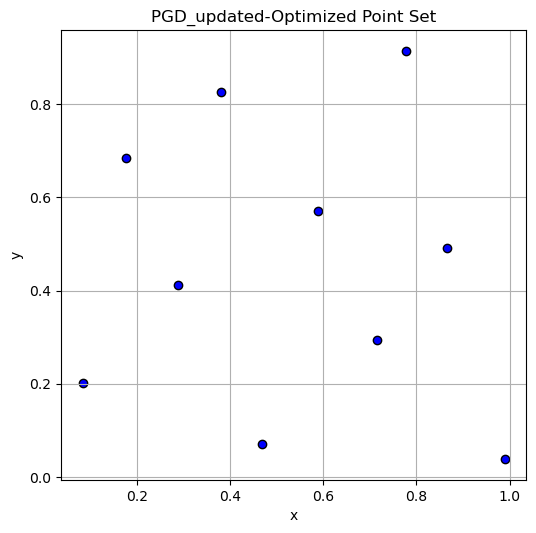

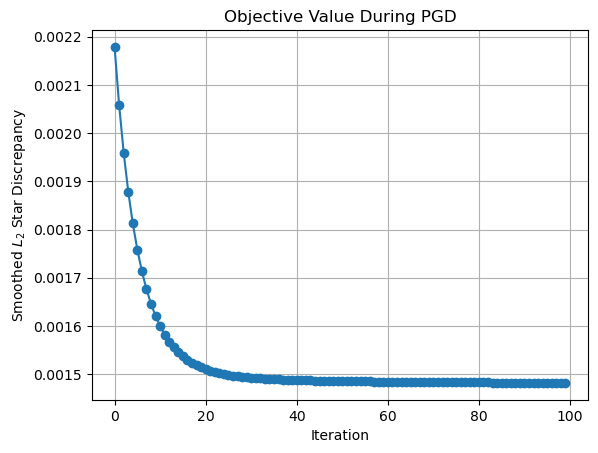

initial set L2 star discrepancy: 0.002326497201966496
Final discrepancy value: 0.0014817827348551221
Points: [[0.99085665 0.03782986]
 [0.38142818 0.82706814]
 [0.58906482 0.57157904]
 [0.08321256 0.20073344]
 [0.77669978 0.91546467]
 [0.28769877 0.41253815]
 [0.71456746 0.29447715]
 [0.17715863 0.6845511 ]
 [0.86556182 0.49130859]
 [0.4694883  0.07033816]]


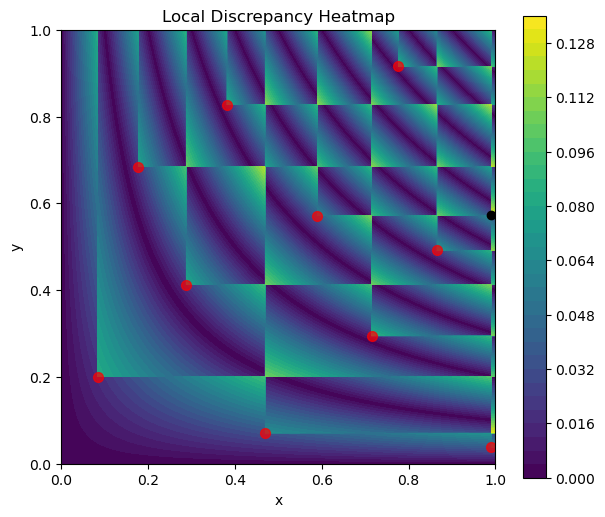

In [13]:
n = 10
d = 2
halton_net = Halton(dimension=d)
init_points = halton_net.gen_samples(n)

plt.figure(figsize=(6,6))
plt.scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
plt.title("original halton Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

print("Points:", init_points)

heatmap_from_array(init_points)



initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)




initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2_updated(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD_updated-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)